[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Bolin_1958/timescales_comparison.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Bolin_1958/timescales_comparison.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Bolin_1958/timescales_comparison.ipynb)

#### Timescales comparison 
##### Bolin
##### Gedzelman

In [1]:
import sys

from dill import settings

from PySDM.attributes.isotopes.delta import isotope

if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [2]:
import numpy as np
from PySDM.physics import si
from PySDM import Formulae
from PySDM_examples.Bolin_1958.common import IsotopeTimescaleCommon
from open_atmos_jupyter_utils import show_plot

In [13]:
any_non_zero_value = 44.0
radii = np.asarray([0.005, 0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.20]) * si.cm
temperature = Formulae().constants.T0 + 10 * si.K

settings = {
    "terminal_velocity":"RogersYau",
    "drop_growth":"Mason1951",
    "diffusion_thermics":"Neglect",
    "saturation_vapour_pressure":"AugustRocheMagnus",
    "ventilation":"Froessling1938",
    "particle_shape_and_density":"LiquidSpheres",
    "air_dynamic_viscosity":"ZografosEtAl1987",
}

variants = {
    'bolin': {
        'constants': {"BOLIN_ISOTOPE_TIMESCALE_COEFF_C1": 1.63},
        'isotope_relaxation_timescale': "Bolin1958",
    },
    'miyake': {
        'isotope_relaxation_timescale': "MiyakeEtAl1968",
    }
}

adjustment_time = {}
for variant, kwargs in variants.items():
    formulae = Formulae(
        **{**kwargs, **settings},
    )
    const = formulae.constants
    isotope_functions = IsotopeTimescaleCommon(formulae=formulae, temperature=temperature, radii=radii)
    
    r_dr_dt = isotope_functions.r_dr_dt_fun(K=any_non_zero_value)
    adjustment_time[variant] = formulae.isotope_relaxation_timescale.tau_of_rdrdt(
        radius = radii,
        r_dr_dt = r_dr_dt(RH=0, RH_eq=1, lv=0),
        alpha=1
    )
    
    if variant == 'bolin':
        vent_coeff = isotope_functions.vent_coeff_fun()
        alpha = 0.75
        c1_coeff = isotope_functions.formulae.isotope_relaxation_timescale.c1_coeff(
            vent_coeff_iso = vent_coeff,
            vent_coeff = vent_coeff,
            D_iso = isotope_functions.D,
            D = isotope_functions.D,
            alpha = alpha,
            rho_env_iso = 0,
            rho_env = 0,
            M_iso = 1, #any number const.M_3H,
            pvs_iso = 1, #any number
            pvs_water =1, #any number isotope_functions.formulae.saturation_vapour_pressure.pvs_water(temperature),
            temperature = isotope_functions.temperature,
        )
        print(f"c1 = {c1_coeff}")
        adjustment_time['bolin_c1'] = formulae.isotope_relaxation_timescale.tau_of_rdrdt_c1(
        radius = radii,
        r_dr_dt = r_dr_dt(RH=0, RH_eq=1, lv=0),
        alpha=1,
        c1_coeff = c1_coeff
    )

c1 = [1.33333333 1.33333333 1.33333333 1.33333333 1.33333333 1.33333333
 1.33333333 1.33333333]


In [4]:
adjustment_time

{'bolin': array([  4.58101402,  14.2607967 ,  53.52400906, 128.5239839 ,
        214.34582876, 316.23237039, 542.50772639, 791.741067  ]),
 'bolin_c1': array([  2.10782854,   6.56171627,  24.62761153,  59.13680241,
         98.62538133, 145.50569189, 249.6201195 , 364.29803696]),
 'miyake': array([  2.81043805,   8.74895503,  32.83681537,  78.84906987,
        131.50050844, 194.00758919, 332.82682601, 485.73071595])}

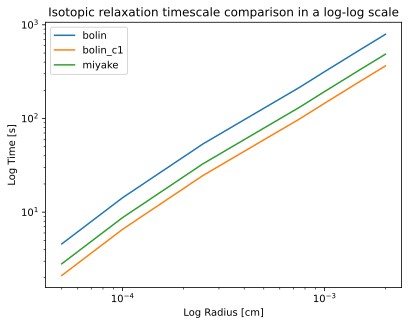

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
for variant, time in adjustment_time.items():
    ax.loglog(radii, time * si.s, label=variant)
ax.set_title('Isotopic relaxation timescale comparison in a log-log scale')
ax.set_xlabel('Log Radius [cm]')
ax.set_ylabel('Log Time [s]')
ax.legend()
show_plot('timescales_comparison.pdf')